<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #3 - Parte II: Análisis de sentimientos usando RNN </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Noviembre 2016._

## Tabla de Contenidos
* [Parte (a)](#a)
* [Parte (b)](#b)
* [Parte (c)](#c)
* [Parte (d)](#d)
* [Parte (e)](#e)
* [Parte (f)](#f)
* [Parte (g)](#g)
* [Parte (h)](#h)

In [258]:
import numpy as np
# fixing the seed
np.random.seed(3)

from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(8)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Flatten, Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.metrics import binary_accuracy

import sys
sys.path.append('../')
from keras_helper import load_keras_model as load
from keras_helper import save_keras_model as save

# Directory where models will be saved
base_dir = 'models/'

<div id='a'/>
## Parte (a)

Se carga la el _dataset_ fijando la semilla, para la reproducibilidad de los experimentos.

In [338]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)

<div id='b'/>
## Parte (b)

In [345]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print('Cantidad de palabras en el dataset: {0}'.format(max(X.max())))
print('Cantidad de comentarios en el dataset: {0}'.format(len(y)))

Cantidad de palabras en el dataset: 88455
Cantidad de comentarios en el dataset: 50000


Se muestra a continuación la distribución del largo de los comentarios por medio de un _boxplot_, y por la distribución en frecuencia de estos.

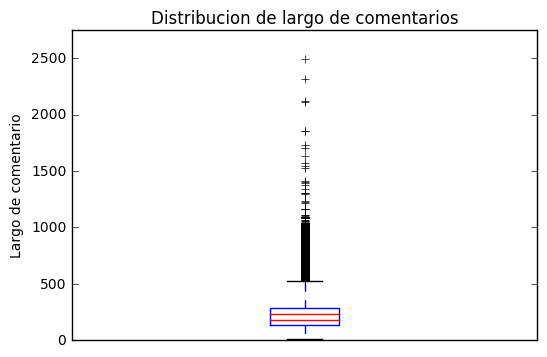

In [46]:
lengths = map(len, X)
plt.boxplot(lengths, showmeans=True, meanline=True)
plt.title("Distribucion de largo de comentarios")
plt.ylabel("Largo de comentario")
plt.ylim([0,2750])
plt.xticks([])
plt.show()

Se puede notar que son muy pocos los comentarios que superan las `1000` palabras, estando además la mayor parte de estos por bajo las `500` palabras. Esto justifica la elección que se hace a continuación, de trabajar con los comentarios con hasta `500` palabras, pues se está considerando una parte representativa de estos.  

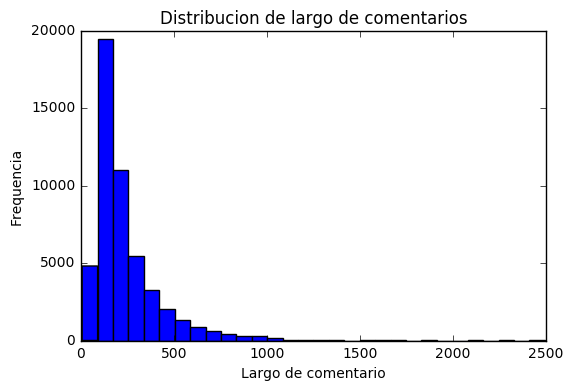

In [42]:
plt.hist(lengths, bins=30)
plt.title("Distribucion de largo de comentarios")
plt.xlabel("Largo de comentario")
plt.ylabel("Frequencia")
plt.show()

<div id='c'/>
## Parte (c)

En el código siguiente se cargan los comentarios con un largo máximo de `500` palabras, tal como se justificó anteriormente. Es importante hacer notar la codificación de las palabras en el dataset; Cada palabra está asociada a un entero positivo, de modo que la palabra asociada a `k`, es la `k-ésima` palabra que más se repite en el _dataset_. En este caso, para todos los comentarios se extraen sólo las `3000` palabras "más importantes" (con mayor frecuencia).

In [348]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=3000, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

<div id='d'/>
## Parte (d)

La función que se provee a continuación, permite producir modelos de RNN con `LSTM` de forma genérica.

In [131]:
def generate_model(top_words, embedding_length, n_lstm_units=100, dropout=None):
    model = Sequential()
    model.add(Embedding(top_words, embedding_length, input_length=500))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(LSTM(n_lstm_units))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

El modelo producido es el que se muestra a continuación.

In [80]:
model = generate_model(top_words=3000, embedding_length=32, n_lstm_units=100)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 500, 32)       96000       embedding_input_5[0][0]          
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (None, 100)           53200       embedding_5[0][0]                
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 1)             101         lstm_5[0][0]                     
Total params: 149301
____________________________________________________________________________________________________


In [81]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 585s - loss: 0.4683 - acc: 0.7636 - val_loss: 0.3304 - val_acc: 0.8630
Epoch 2/3
25000/25000 [==============================] - 563s - loss: 0.3116 - acc: 0.8714 - val_loss: 0.3233 - val_acc: 0.8638
Epoch 3/3
25000/25000 [==============================] - 540s - loss: 0.2661 - acc: 0.8937 - val_loss: 0.3633 - val_acc: 0.8420


Y los siguientes son los resultados sobre el conjunto de prueba. Como se puede ver, siendo esta la primera prueba realizada y con un bajo número de `epochs`, se alcanzó un `accuracy` bastante alto.

In [86]:
# evaluating the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {0}'.format(scores[0]))
print('Test accuracy: {0}'.format(scores[1]))

Test loss: 0.36333145184
Test accuracy: 0.84196


<div id='e'/>
## Parte (e)

El siguiente código fue ejecutado por medio del script `2e.py` en cluster de _CCTVAL_. Para la misma configuración de red anterior, se varía el largo del _embedding_ entre los valores `[8,16,32,64,128,256,512,1024]`.

**Nota**: El proceso de _embedding_ corresponde a un mapeo, que transforma el espacio discreto de características de los vectores de entrada, a un espacio continuo y usualmente de menor dimensión.

In [ ]:
###################################################################
## WARNING: The execution of this cell is computationally expensive
###################################################################

embedding_lengths = [8,16,32,64,128,256,512,1024]
acc_tr = []
acc_ts = []

for length in embedding_lengths:
    model = generate_model(top_words=3000, embedding_length=length, n_lstm_units=100)
    # fitting the model
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    # evaluating the model
    acc_tr.append(model.evaluate(X_train, y_train)[1])
    acc_ts.append(model.evaluate(X_test, y_test)[1])
    # saving the model
    save(model, 'lstm100_embedding{0}'.format(length), base_dir=base_dir)

In [97]:
# carga y evaluacion de modelo previamente computados
acc_tr = []
acc_ts = []

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}'.format(length))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model

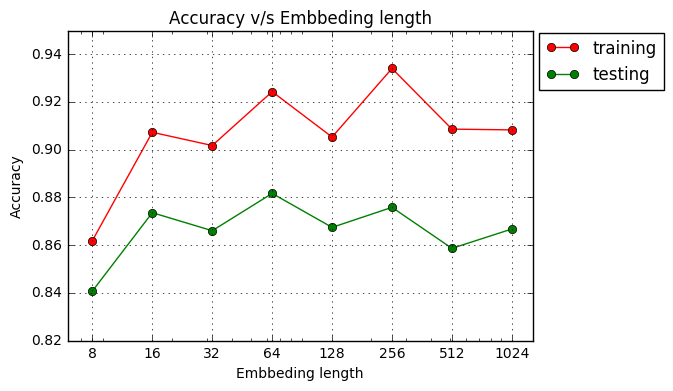

In [122]:
def acc_plot(acc_tr, acc_ts):
    embedding_lengths = [8,16,32,64,128,256,512,1024]    
    plt.semilogx(embedding_lengths, acc_tr, 'ro-', label='training')
    plt.semilogx(embedding_lengths, acc_ts, 'go-', label='testing')
    plt.xticks(embedding_lengths, embedding_lengths)
    plt.xlabel('Embedding length')
    plt.ylabel('Accuracy')
    plt.title('Accuracy v/s Embedding length')
    plt.xlim(6,1300)
    plt.ylim(0.82, 0.95)
    plt.legend(bbox_to_anchor=(1.3, 1.02))
    plt.grid()
    plt.show()

acc_plot(acc_tr, acc_ts)

Se puede notar en los resultados sobre el conjunto de _test_, que tamaños de _embeddings_ muy bajos o muy altos deterioran la _performance_ de la red. El valor óptimo se obtienen para `embedding_length=64`. Sin embargo, hay que tener en cuenta que a mayor tamaño de _embedding_, mayor serán el número de conexiones y complejidad de la red (y por tanto también el tiempo de entrenamiento).

<div id='f'/>
## Parte (f)

El siguiente código fue ejecutado por medio del script `2f.py` en cluster de _CCTVAL_. Para la misma configuración de red `LSTM`, se prueba para combinación de valores `embedding_lengths = [8,16,32,64,128,256,512,1024]` y `top_words = [1000, 3000, 5000, 10000, 15000]`.

In [ ]:
###################################################################
## WARNING: The execution of this cell is computationally expensive
###################################################################

embedding_lengths = [8,16,32,64,128,256,512,1024]
top_words_list = [1000, 3000, 5000, 10000, 15000]
acc_tr = []
acc_ts = []

for top_words in top_words_list:
    # loading data
    (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
    X_train = sequence.pad_sequences(X_train, maxlen=500)
    X_test = sequence.pad_sequences(X_test, maxlen=500)
    
    for length in embedding_lengths:
        model = generate_model(top_words=top_words , embedding_length=length, n_lstm_units=100)
        # fitting the model
        hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
        # evaluating the model
        acc_tr.append(model.evaluate(X_train, y_train)[1])
        acc_ts.append(model.evaluate(X_test, y_test)[1])
        # saving the model
        save(model, 'lstm100_embedding{0}_tw{1}'.format(length, top_words), base_dir=base_dir)
        # releasing memory
        del model
    # releasing memory
    del X_train, X_test, y_train, y_test, model 

### `top_words=1000` 

In [171]:
# carga y evaluacion de modelo previamente computados
top_words = 1000

acc_tr_tw1000 = []
acc_ts_tw1000 = []

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}_tw{1}'.format(length, top_words))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr_tw1000.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts_tw1000.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model
    
del X_train, y_train, X_test, y_test

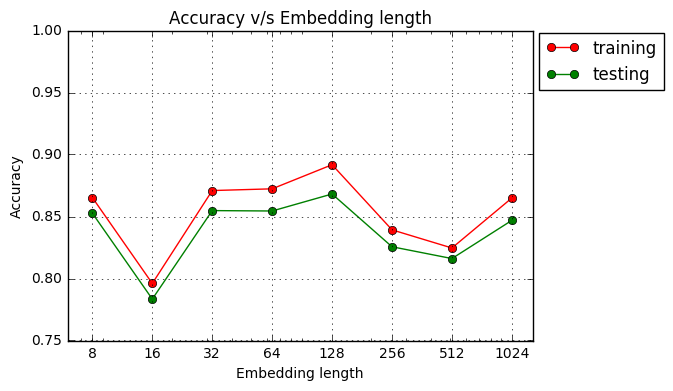

In [198]:
acc_plot(acc_tr_tw1000, acc_ts_tw1000)

### `top_words=3000`

In [157]:
# carga y evaluacion de modelo previamente computados
top_words = 3000

acc_tr_tw3000 = []
acc_ts_tw3000 = []

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}_tw{1}'.format(length, top_words))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr_tw3000.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts_tw3000.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model
    
del X_train, y_train, X_test, y_test

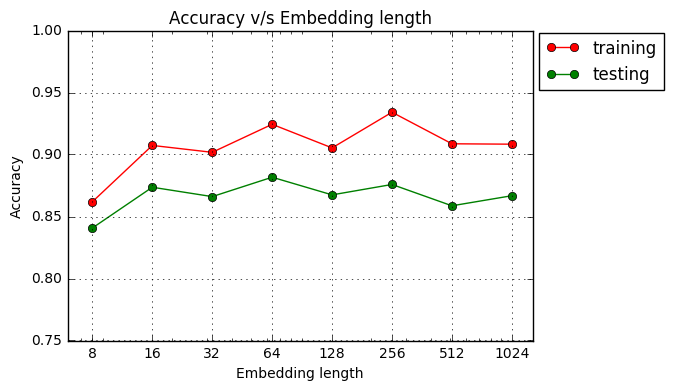

In [199]:
acc_plot(acc_tr_tw3000, acc_ts_tw3000)

### `top_words = 5000`

In [158]:
# carga y evaluacion de modelo previamente computados
top_words = 5000

acc_tr_tw5000 = []
acc_ts_tw5000 = []

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}_tw{1}'.format(length, top_words))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr_tw5000.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts_tw5000.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model
    
del X_train, y_train, X_test, y_test

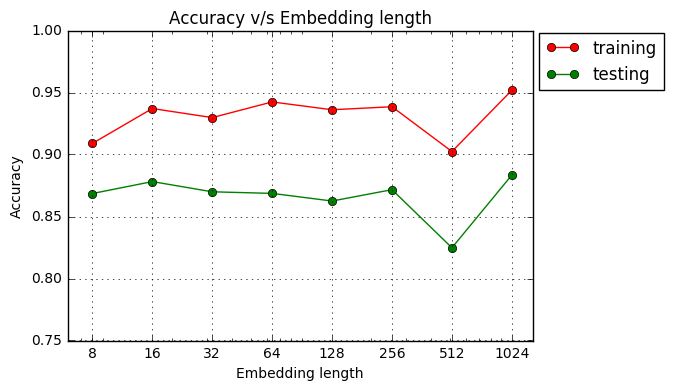

In [200]:
acc_plot(acc_tr_tw5000, acc_ts_tw5000)

### `top_words = 10000`

In [159]:
# carga y evaluacion de modelo previamente computados
top_words = 10000

acc_tr_tw10000 = []
acc_ts_tw10000 = []

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}_tw{1}'.format(length, top_words))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr_tw10000.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts_tw10000.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model
    
del X_train, y_train, X_test, y_test

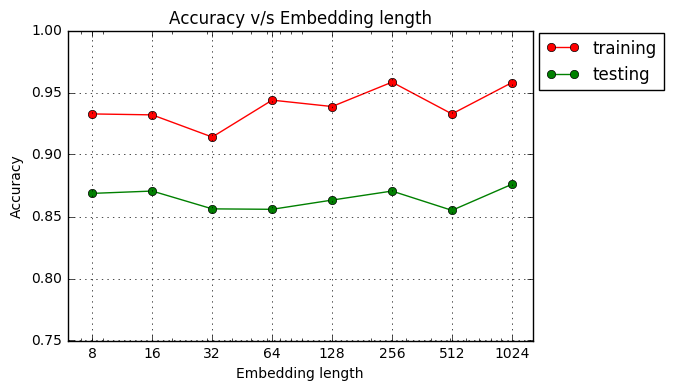

In [201]:
acc_plot(acc_tr_tw10000, acc_ts_tw10000)

### `top_words=15000`

In [160]:
# carga y evaluacion de modelos previamente computados
top_words = 15000

acc_tr_tw15000 = []
acc_ts_tw15000 = []

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

for length in embedding_lengths:
    model = load(base_dir+'lstm100_embedding{0}_tw{1}'.format(length, top_words))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    acc_tr_tw15000.append( model.evaluate(X_train, y_train, verbose=0)[1] )
    acc_ts_tw15000.append( model.evaluate(X_test, y_test, verbose=0)[1] )
    del model
    
del X_train, y_train, X_test, y_test

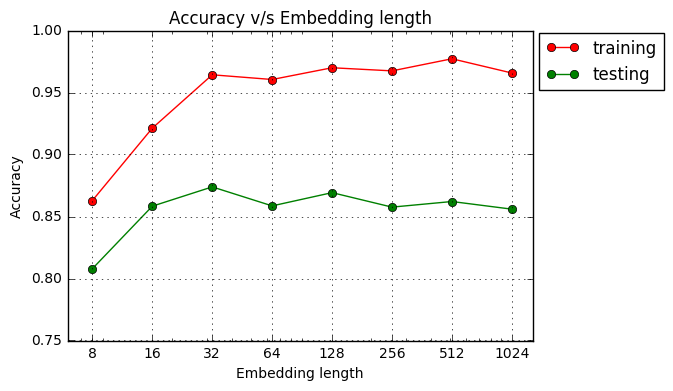

In [202]:
acc_plot(acc_tr_tw15000, acc_ts_tw15000)

### Comparación final

A continuación se presenta la comparación final de los resultados anteriores, sobre el conjunto de _test_.


Se puede apreciar que no hay mejoras al agregar las `10000` (o más) palabras más frecuentes, esto es, las palabras con baja frecuencia efectivamente no están aportando en gran medida a la predicción de la valoración del comentario. Por otro lado tener una cantidad muy baja de palabras (`1000`), deteriora el desempeño en gran medida, es decir, se están dejando de lado palabras que efectivamente ayudan a predecir la valoración del comentario.


Con `top_words=3000` se tiene el comportamiento más estable. Los resultados con mejor desempeño son:


1. `top_words=5000 & embedding=1024`
2. `top_words=3000 & embedding=64`
3. `top_words=5000 & embedding=16`

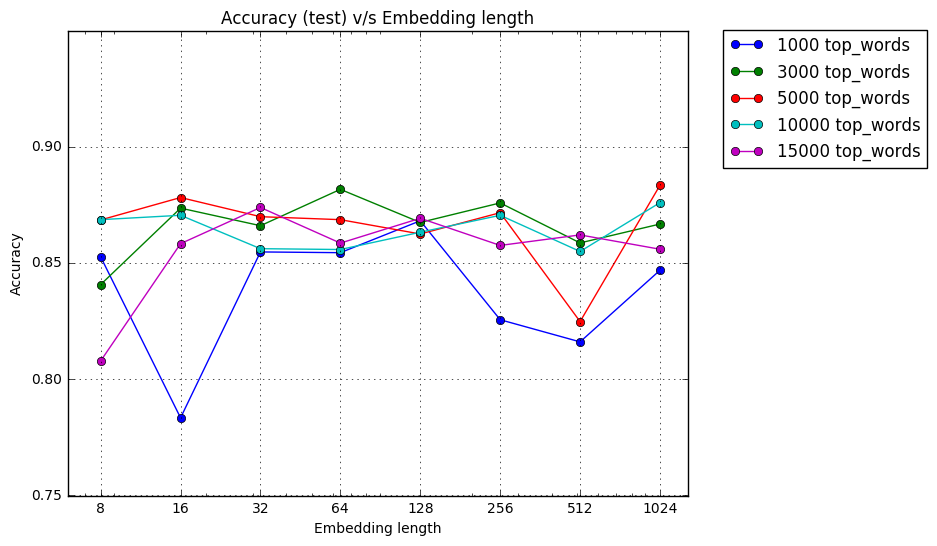

In [216]:
embedding_lengths = [8,16,32,64,128,256,512,1024] 
plt.figure(figsize=(8,6))
plt.semilogx(embedding_lengths, acc_ts_tw1000, 'o-', label='1000 top_words')
plt.semilogx(embedding_lengths, acc_ts_tw3000, 'o-', label='3000 top_words')
plt.semilogx(embedding_lengths, acc_ts_tw5000, 'o-', label='5000 top_words')
plt.semilogx(embedding_lengths, acc_ts_tw10000, 'o-', label='10000 top_words')
plt.semilogx(embedding_lengths, acc_ts_tw15000, 'o-', label='15000 top_words')
plt.xticks(embedding_lengths, embedding_lengths)
plt.xlabel('Embedding length')
plt.ylabel('Accuracy')
plt.title('Accuracy (test) v/s Embedding length')
plt.xlim(6,1300)
plt.ylim(0.75, 0.95)
plt.legend(bbox_to_anchor=(1.4, 1.02))
plt.grid()
plt.show()

<div id='g'/>
## Parte (g)

Para la misma configuración de red `LSTM` anterior (d), se utiliza la técnica de `dropout` con proporción `0.2` sobre la conexiones que van de la capa _embedding_ a la _LSTM_ y de la _LSTM_ a la _dense_, tal como se muestra a continuación.

In [90]:
model = generate_model(top_words=3000, embedding_length=32, n_lstm_units=100, dropout=0.2)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_8 (Embedding)          (None, 500, 32)       96000       embedding_input_8[0][0]          
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 500, 32)       0           embedding_8[0][0]                
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 100)           53200       dropout_5[0][0]                  
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 100)           0           lstm_8[0][0]                     
___________________________________________________________________________________________

In [91]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 539s - loss: 0.5708 - acc: 0.7020 - val_loss: 0.4717 - val_acc: 0.7919
Epoch 2/3
25000/25000 [==============================] - 534s - loss: 0.3598 - acc: 0.8498 - val_loss: 0.3207 - val_acc: 0.8634
Epoch 3/3
25000/25000 [==============================] - 528s - loss: 0.2834 - acc: 0.8853 - val_loss: 0.3509 - val_acc: 0.8558


El resultado sobre el conjunto de _test_ que se muestra a continuación, refleja que _dropout_ produce un mejora respecto al resultado observado en la __Parte (d)__ (`Test accuracy: 0.84196`).

Los motivos de la mejora en desempeño se pueden deber a:
* Como se sabe _dropout_ es una técnica de regularización, dado que al ajustar sólo un subconjunto de los pesos de la red en cada _epoch_, se evita caer en _overfitting_ y por lo tanto genera modelos con mayor capacidad de generalización.
* Desde la perspectiva que mira a _dropout_ como análogo a un ensamblado, la mejora de desempeño puede entenderse como que el comité de los modelos obtenidos al entrenar en cada _epoch_, produce una predicción más estable y robusta.

In [92]:
# evaluating the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {0}'.format(scores[0]))
print('Test accuracy: {0}'.format(scores[1]))

Test loss: 0.350875819955
Test accuracy: 0.8558


<div id='h'/>
## Parte (h)

__Nota__: En base a los resultados obtenidos anteriormente, la configuración que se utilizará para las redes `LSTM` de aquí en adelante, será aquella con `top_words=3000 & embedding_length=16`. Esto se hace considerando el _trade-off_ entre la complejidad computacional y la capacidad del modelo.

### Aumentar `n_epoch`

Todos los modelos anteriores fueron entrenados con `n_epoch=3`, lo cual es una cantidad muy baja comparada a la cantidad de _epochs_ que se suelen utilizar para entrenar una `MLP`. Por lo tanto la primera prueba para rebajar el error consiste en aumentar `n_epoch`.

In [132]:
embedding_length = 16
top_words = 3000

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# generation of model
model = generate_model(top_words, embedding_length, n_lstm_units=100)
# fitting of model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=50, batch_size=64)
# saving the model
save(model, 'lstm100_embedding{0}_tw{1}_50epoch'.format(embedding_length, top_words), base_dir=base_dir)

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 516s - loss: 0.5039 - acc: 0.7520 - val_loss: 0.3561 - val_acc: 0.8489
Epoch 2/50
25000/25000 [==============================] - 516s - loss: 0.3615 - acc: 0.8440 - val_loss: 0.3704 - val_acc: 0.8448
Epoch 3/50
25000/25000 [==============================] - 509s - loss: 0.3060 - acc: 0.8772 - val_loss: 0.3155 - val_acc: 0.8729
Epoch 4/50
25000/25000 [==============================] - 513s - loss: 0.2555 - acc: 0.9014 - val_loss: 0.3113 - val_acc: 0.8778
Epoch 5/50
25000/25000 [==============================] - 535s - loss: 0.2583 - acc: 0.8975 - val_loss: 0.3340 - val_acc: 0.8632
Epoch 6/50
25000/25000 [==============================] - 687s - loss: 0.2294 - acc: 0.9106 - val_loss: 0.3187 - val_acc: 0.8787
Epoch 7/50
25000/25000 [==============================] - 889s - loss: 0.2022 - acc: 0.9240 - val_loss: 0.3219 - val_acc: 0.8768
Epoch 8/50
25000/25000 [=======================

TypeError: save_keras_model() got an unexpected keyword argument 'base_dir'

Como se aprecia en la figura siguiente, no hay mejoras al aumentar el número de `epoch`. Es más, se nota una tendencia a la baja en el `accuracy`, lo cual está de acuerdo con el fenómeno del _overfitting_. Mientras más se adapta la red al conjunto de entrenamiento (mayor cantidad de `epoch`), más sobre ajustado será el modelo a los datos y menor será su capacidad de generalización.

Se concluye que dejar el parámetro `n_epoch=3` es una elección adecuada para evitar el _overfittting_.

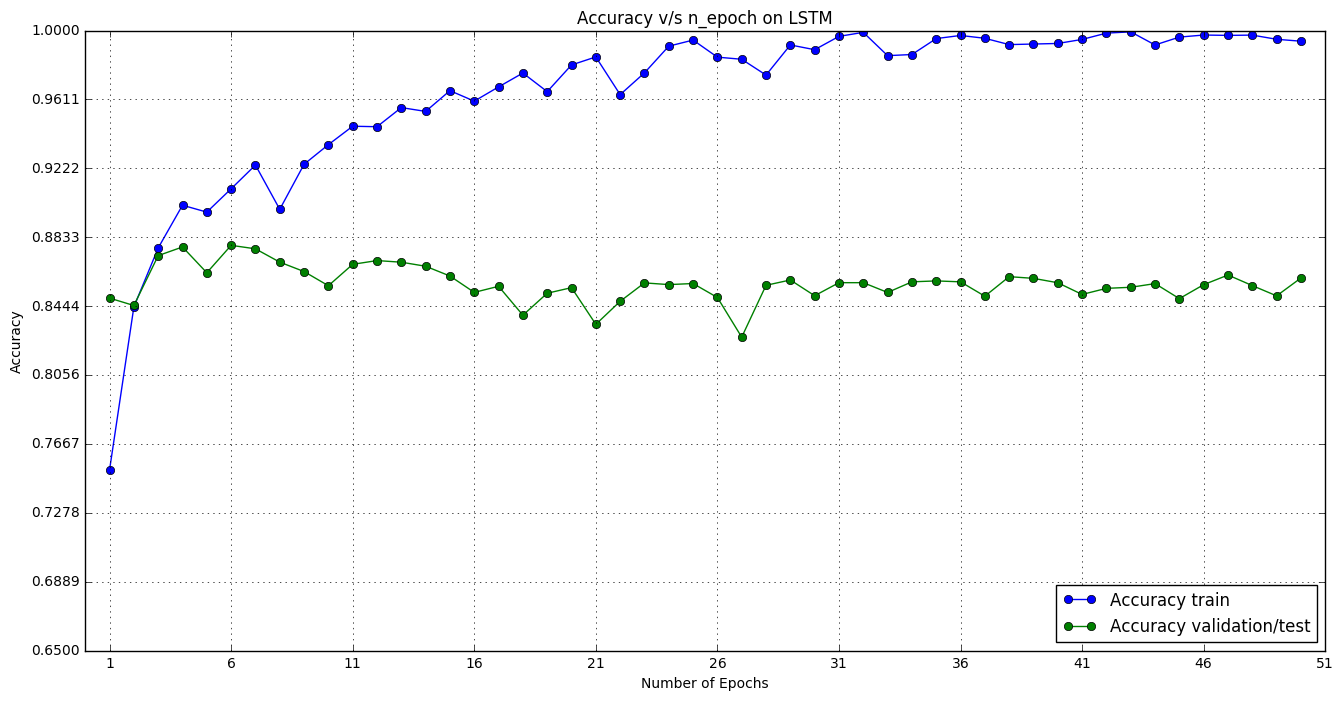

In [146]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,11))
ax.set_yticks(np.linspace(0.65,1,10))
plt.xlim(0,51)
plt.ylim(0.65,1)
plt.plot(range(1,51), hist.history['acc'], 'bo-', label='Accuracy train')
plt.plot(range(1,51), hist.history['val_acc'], 'go-', label='Accuracy validation/test')
plt.legend(loc=4)
plt.title('Accuracy v/s n_epoch on LSTM')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

### Aumentar número de unidades `LSTM`

En todas las redes `LSTM` anteriores la cantidad de unidades se ha mantenido fija en `100`. Debido a la dificultad del problema quizas una arquitectura más compleja sea de utilidad, por ello se prueba con distinta cantidad de unidades.

En vista de que todos los modelos de a continuación son de complejidad creciente, se utiliza `dropout` como técnica de regularización.

In [126]:
n_units_list = [200, 300,400, 500, 600]

for n_units in n_units_list:
    model = generate_model(embedding_length=16, top_words=3000, n_lstm_units=n_units, dropout=0.2)
    # fitting the model
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    # evaluating the model
    acc_tr.append(model.evaluate(X_train, y_train)[1])
    acc_ts.append(model.evaluate(X_test, y_test)[1])
    # saving the model
    save(model, 'lstm{2}_embedding{0}_{1}tw'.format(embedding_length, top_words, n_units), base_dir=base_dir)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_9 (Embedding)          (None, 500, 32)       160000      embedding_input_19[0][0]         
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 500, 32)       0           embedding_9[0][0]                
____________________________________________________________________________________________________
lstm_9 (LSTM)                    (None, 200)           186400      dropout_7[0][0]                  
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 200)           0           lstm_9[0][0]                     
___________________________________________________________________________________________

#### 200 unidades `LSTM`

In [330]:
# carga de modelos previamente computados
model = load(base_dir+'lstm200_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.278987831979 
Training accuracy: 0.89508 

Testing loss: 0.338616101143 
Testing accuracy: 0.86248 



#### 300 unidades `LSTM`

In [331]:
# carga de modelos previamente computados
model = load(base_dir+'lstm300_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.27721161516 
Training accuracy: 0.88556 

Testing loss: 0.317110274152 
Testing accuracy: 0.86616 



#### 400 unidades `LSTM`

In [332]:
# carga de modelos previamente computados
model = load(base_dir+'lstm400_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.379314427857 
Training accuracy: 0.8408 

Testing loss: 0.411116701965 
Testing accuracy: 0.82428 



#### 500 unidades `LSTM`

In [334]:
# carga de modelos previamente computados
model = load(base_dir+'lstm500_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.48050919898 
Training accuracy: 0.78816 

Testing loss: 0.511515475512 
Testing accuracy: 0.7572 



#### 600 unidades `LSTM`

In [333]:
# carga de modelos previamente computados
model = load(base_dir+'lstm600_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.609038159542 
Training accuracy: 0.64884 

Testing loss: 0.642684984055 
Testing accuracy: 0.63296 



En el gráfico siguiente se resumen los resultados anteriores. Se nota que si bien hay mejoras, estas no son  significativas. Por otro lado, con un número muy elevado de unidades el desempeño de los modelos obtenidos se ve deteriorado. Esto era un comportamiento esperado, dado que los modelos de alta complejidad (mayor número de unidades) tienen mayor libertad para adaptarse y aprender el conjunto de entrenamiento, bajando su capacidad de generalización.

Por estos motivos se seguirán ocupando redes con `n_units=100`, pues producen resultados buenos y son computacionalmente menos costosas. (__Nota__: Los tiempos de entrenamiento y evaluación para el resto de redes aumenta en gran medida).

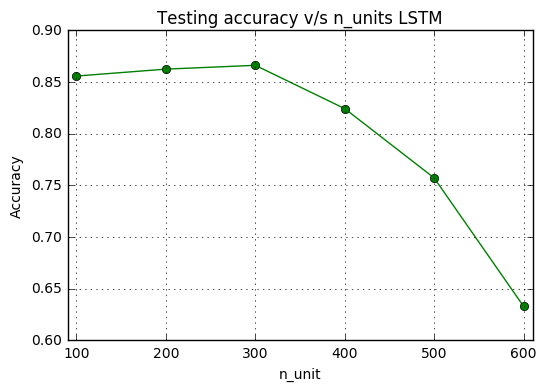

In [359]:
acc_list = [0.8558, 0.86248, 0.86616, 0.82428, 0.7572, 0.63296]
plt.plot([100,200,300,400,500,600], acc_list, 'go-')
plt.xlim(90,610)
plt.xlabel('n_unit')
plt.ylabel('Accuracy')
plt.title('Testing accuracy v/s n_units LSTM')
plt.grid()

### Aumentando el tamaño de `batch_size`

La implementación de redes `LSTM` en `keras` realiza un _reset_ del estado de la red (estado de unidades `LSTM`) después del entrenamiento de un `mini batch`, durante el proceso de entrenamiento. Esto puede ser controlado por medio del parámetro `stateful`, sin embargo otra opción es cambiar el tamaño del `batch_size` utilizado. Todos los experimentos anteriores utilizan `batch_size=64`, por lo que se prueba a continuación con `batch_size=512` y `batch_size=1024`.


El resultado para `batch_size=512` es bastante similar al obtenido sin modificar el _batch_. Sin embargo el `accuracy` obtenido con `batch_size=1024` es muy baja. Esto puede entenderse del siguiente modo: Dado que estamos manteniendo el estado de las unidades `LSTM` durante más ejemplos de entrenamiento, se está forzando a relacionar/correlacionar en mayor medida los datos de entrenamiento, afectando de este modo las características que computan cada unidad `LSTM`.

#### `batch_size=512`

In [335]:
# carga de modelos previamente computados
model = load(base_dir+'lstm100_embedding16_tw3000_bs512')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.348227112684 
Training accuracy: 0.85952 

Testing loss: 0.369533306861 
Testing accuracy: 0.84576 



#### `batch_size=1024`

In [336]:
# carga de modelos previamente computados
model = load(base_dir+'lstm100_embedding16_tw3000_bs1024')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.605263822708 
Training accuracy: 0.76012 

Testing loss: 0.618512816162 
Testing accuracy: 0.745 



### `MLP` tradicional

A modo de prueba se utiliza un `MLP` tradicional, con la siguiente arquitectura:
* Misma capa de `Embedding` que para los casos anteriores.
* Dos capas ocultas de tamaños `2*embedding_length` y `embedding_length` respectivamente.
* Funciones de activación `relu`.
* `n_epoch=50`.

In [229]:
embedding_length = 16
top_words = 3000

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(Flatten())
model.add(Dense(2*embedding_length, activation='relu'))
model.add(Dense(embedding_length, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_12 (Embedding)         (None, 500, 16)       48000       embedding_input_72[0][0]         
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 8000)          0           embedding_12[0][0]               
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 32)            256032      flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 16)            528         dense_14[0][0]                   
___________________________________________________________________________________________

In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, nb_epoch=50, verbose=0, validation_data=(X_test, y_test))
# saving the model
save(model, 'MLP_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

El resultado siguiente muestra como el `MLP` ajusta perfectamente el conjunto de entrenamiento, obteniendo de todas formas un buen desempeño en el conjunto de prueba. 

In [236]:
# carga de modelos previamente computados
model = load(base_dir+'MLP_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 1.2001039026e-07 
Training accuracy: 1.0 

Testing loss: 1.88581708025 
Testing accuracy: 0.83628 



### `MLP` + `dropout`

Para evitar el sobreajuste anterior se agrega `dropout` con proporción `0.2` en todas las conexiones de la red, tal como se muestra en el siguiente sumario.

In [232]:
embedding_length = 16
top_words = 3000

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(2*embedding_length, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(embedding_length, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_13 (Embedding)         (None, 500, 16)       48000       embedding_input_73[0][0]         
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 500, 16)       0           embedding_13[0][0]               
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 8000)          0           dropout_9[0][0]                  
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 32)            256032      flatten_3[0][0]                  
___________________________________________________________________________________________

In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, nb_epoch=50, verbose=0, validation_data=(X_test, y_test))
# saving the model
save(model, 'MLP_dropout_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

Se nota que pese a que se agregó `dropout` como técnica de regularización, sigue ajustando perfectamente el conjunto de entrenamiento. Sin embargo también aumento el _accuracy_ sobre el conjunto de prueba, logrando de este modo aumentar la capacidad de generalización.

In [238]:
# carga de modelos previamente computados
model = load(base_dir+'MLP_dropout_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.000138768130544 
Training accuracy: 1.0 

Testing loss: 0.949051646168 
Testing accuracy: 0.8562 



###  `GRU` (Gated Recurrent Unit)

Se prueba ahora una red simple con unidades `GRU`, las que sabemos, son un modelo simplificado de las `LSTM`. La arquitectura es la misma que para las redes `LSTM` anteriores.

In [239]:
embedding_length = 16
top_words = 3000
n_gru_units = 100

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(LSTM(n_gru_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_14 (Embedding)         (None, 500, 16)       48000       embedding_input_77[0][0]         
____________________________________________________________________________________________________
lstm_11 (LSTM)                   (None, 100)           46800       embedding_14[0][0]               
____________________________________________________________________________________________________
dense_20 (Dense)                 (None, 1)             101         lstm_11[0][0]                    
Total params: 94901
____________________________________________________________________________________________________


In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
# evaluating the model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)
# saving the model
save(model, 'gru100_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

El resultado muestra una mejora sustancial sobre el conjunto de pruebas. Esto puede entenderse dado que este modelo es de _menor complejidad_, y por lo tanto tiene menor capacidad para caer en _overfitting_. Como comentario anexo, es notoria la baja en tiempo de computación que requiere entrenar esta _GRU_.

In [250]:
# carga de modelos previamente computados
model = load(base_dir+'gru100_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.243197497542 
Training accuracy: 0.90704 

Testing loss: 0.317315945146 
Testing accuracy: 0.87216 



### `Stacked LSTM`

Una variante _deep_ interesante es apilar capas `LSTM` consecutivamente. El modelo siguiente realiza esto, con dos capas `LSTM`, con `100` y `50` unidades respectivamente.  

In [242]:
embedding_length = 16
top_words = 3000
n_lstm_units = 100

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(LSTM(n_lstm_units, return_sequences=True))
model.add(LSTM(n_lstm_units/2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_15 (Embedding)         (None, 500, 16)       48000       embedding_input_79[0][0]         
____________________________________________________________________________________________________
lstm_12 (LSTM)                   (None, 500, 100)      46800       embedding_15[0][0]               
____________________________________________________________________________________________________
lstm_13 (LSTM)                   (None, 50)            30200       lstm_12[0][0]                    
____________________________________________________________________________________________________
dense_21 (Dense)                 (None, 1)             51          lstm_13[0][0]                    
Total params: 125051
______________________________________________________________________

In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
# evaluating the model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)
# saving the model
save(model, 'lstm-stacked_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

Los resultados obtenidos son malos. Los motivos de este comportamiento puede ser varios:
1. Requiere de mayor cantidad de _epochs_.
2. La arquitectura _deep_ es muy compleja (_overfitting_).

In [252]:
# carga de modelos previamente computados
model = load(base_dir+'lstm-stacked_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.517850275593 
Training accuracy: 0.74472 

Testing loss: 0.538382988186 
Testing accuracy: 0.72444 



### `Stacked LSTM + dropout` 

En un intento por mejorar el modelo anterior, se propone utilizar `dropout` con proporción `0.2` en todas las conexiones de la red, como se muestra en el sumario siguiente.

In [314]:
embedding_length = 16
top_words = 3000
n_lstm_units = 100
dropout = 0.2

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(Dropout(dropout))
model.add(LSTM(n_lstm_units, return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(n_lstm_units/2))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_16 (Embedding)         (None, 500, 16)       48000       embedding_input_115[0][0]        
____________________________________________________________________________________________________
dropout_12 (Dropout)             (None, 500, 16)       0           embedding_16[0][0]               
____________________________________________________________________________________________________
lstm_14 (LSTM)                   (None, 500, 100)      46800       dropout_12[0][0]                 
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 500, 100)      0           lstm_14[0][0]                    
___________________________________________________________________________________________

In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
# saving the model
save(model, 'lstm-stacked-dropout_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

In [253]:
# carga de modelos previamente computados
model = load(base_dir+'lstm-stacked-dropout_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

El `accuracy` mejora de manera sustancial, pero sin embargo sigue siendo inferior al de las redes `LSTM` clásicas (no _deep_). Falta experimentar variando otros parámetros como: `n_epoch`, `batch_size` y `n_units`, pero debido a los largos tiempos de entrenamiento, no fue posible probar todas las configuraciones.

In [254]:
# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.386523605957 
Training accuracy: 0.82436 

Testing loss: 0.411050964622 
Testing accuracy: 0.81268 



### `Convolutional layer + LSTM`

Una variante interesante, es agregar una capa convolucional 1D entre la capa de `Embedding` y la `LSTM`, de modo que la red aprenda las características importantes a partir de la representación obtenida en el _embedding_. La siguiente red realiza lo anterior para `embedding_length=16`.

In [315]:
embedding_length = 16
top_words = 3000
n_lstm_units = 100

# building the model
model = Sequential()
model.add(Embedding(top_words, embedding_length, input_length=500))
model.add(Convolution1D(nb_filter=2*embedding_length, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(n_lstm_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_17 (Embedding)         (None, 500, 16)       48000       embedding_input_116[0][0]        
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 32)       1568        embedding_17[0][0]               
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
lstm_16 (LSTM)                   (None, 100)           53200       maxpooling1d_1[0][0]             
___________________________________________________________________________________________

In [ ]:
# fitting the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
# saving the model
save(model, 'lstm-conv_embedding{0}_tw{1}'.format(embedding_length, top_words), base_dir=base_dir)

#### `Embedding=16`

El resultado obtenido es bastante bueno. Se puede concluir que agregar una capa convolucional permite extraer información de características que son útiles en el proceso de predicción posterior.

In [256]:
# carga de modelos previamente computados
model = load(base_dir+'lstm-conv_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.246584612181 
Training accuracy: 0.90436 

Testing loss: 0.313720456265 
Testing accuracy: 0.86996 



#### `Embedding=64` (**)

El _embedding_ realizado por `keras` puede entenderse como una reducción/transformación lineal, desde el espacio original hacia un espacio de dimensión inferior (en este caso `embedding_length=16`). Sin embargo partir con una representación de `16` características puede que limite mucho la capacidad de la capa convolucional. Por esto se prueba con `embedding_length=64` y `2*embedding_length` filtros convolucionales de tamaño `3`.

El resultado obtenido es el mejor para un modelo simple (sólo superado por el ensamblado a continuación), verificando de este modo que en el caso anterior es estaba limitando mucho a la capa convolucional.

In [337]:
# carga de modelos previamente computados
model = load(base_dir+'lstm-conv_embedding64_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# evaluando el modelo
tr = model.evaluate(X_train, y_train, verbose=0)
ts = model.evaluate(X_test, y_test, verbose=0)
print('Training loss: {0} \nTraining accuracy: {1} \n'.format(tr[0],tr[1]))
print('Testing loss: {0} \nTesting accuracy: {1} \n'.format(ts[0],ts[1]))

Training loss: 0.174107593358 
Training accuracy: 0.93852 

Testing loss: 0.283235272328 
Testing accuracy: 0.88508 



### `Ensemble learning:` Ensamblado de redes con mejor desempeño

Como última prueba, se realiza un ensamblado de los modelos anteriores con mejor desempeño. Dado que tales modelos son de distinta naturaleza (__diversos__) y todos son __precisos__ (`accuracy > 0.85`), se espera que el ensamblado mejore la capacidad de predicción.

Se implementan dos funciones de predicción: Por mayoría de votos (`majority`) y por promedio de probabilidades (`probability`).

In [349]:
class Ensemble:
    def __init__(self, model_list):
        self.model_list = model_list
        self.n_estimators = len(model_list)
    
    def predict1(self, X):
        votes = np.zeros(X.shape[0])
        for model in self.model_list:
            votes += (model.predict(X) >= 0.5).astype(int).ravel()
        return (votes >= int(self.n_estimators/2)).astype(np.int)
    
    def predict2(self, X):
        prob = np.zeros(X.shape[0])
        for model in self.model_list:
            prob += model.predict(X).ravel()
        return (prob/self.n_estimators >= 0.5).astype(np.int)
    
    def evaluate(self, X, y, kind='probability'):
        if kind=='majority':
            ypred = self.predict1(X)
        elif kind=='probability':
            ypred = self.predict2(X)
        ytrue = y.astype(np.int)
        return np.sum(ypred==ytrue)/float(len(ytrue))

In [360]:
###########################################
### CONSTRUYENDO EL ENSAMBLADO
###########################################

# se proceden a cargar los modelos con mejor desempeño 
# todos con accuracy superior a 0.8
committee = []

model = load(base_dir+'lstm100_embedding64_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'lstm200_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'lstm300_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'MLP_dropout_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'gru100_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'lstm-conv_embedding16_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = load(base_dir+'lstm-conv_embedding64_tw3000')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
committee.append(model)

model = Ensemble(committee)

In [361]:
# evaluando el modelo
tr = model.evaluate(X_train, y_train, kind='majority')
ts = model.evaluate(X_test, y_test, kind='majority')
print('Training accuracy: {0}'.format(tr))
print('Testing accuracy: {0}'.format(ts))

Training accuracy: 0.92472
Testing accuracy: 0.87972


In [362]:
# evaluando el modelo
tr = model.evaluate(X_train, y_train, kind='probability')
ts = model.evaluate(X_test, y_test, kind='probability')
print('Training accuracy: {0}'.format(tr))
print('Testing accuracy: {0}'.format(ts))

Training accuracy: 0.94608
Testing accuracy: 0.8904


Finalmente el ensamblado que realiza promedio de probabilidades es el que obtiene el mejor desempeño en esta experiencia. La siguiente tabla resume los mejores resultados obtenidos en esta sección (modelos con (__*__) corresponden a los utilizado para el ensamblado):

|             Modelo            | Accuracy |
|:-----------------------------:|:--------:|
| `LSTM100-embedding32`           | 0.84196  |
| `LSTM100-embedding32-drop`      | 0.8558   |
| `LSTM200_embedding16`  (__*__)         | 0.86248  |
| `LSTM300_embedding16`  (__*__)          | 0.86616  |
| `MLP`                           | 0.83628  |
| `MLP-drop`     (__*__)                 | 0.8562   |
| `GRU100-embedding16`     (__*__)       | 0.87216  |
| `stacked-LSTM-drop-embedding16`  | 0.81268  |
| `LSTM-conv-embedding16` (__*__)        | 0.86996  |
| `LSTM-conv-embedding64`  (__*__)       | __0.88508__  |
| `Ensemble`                      |   __0.8904__     |